In [1]:
import torch
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import style
style.use('dark_background')


import warnings
warnings.filterwarnings('ignore')

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = '/home/irina/Documents/PROJECTS/excursion' 

Goals for this notebook:
- Use 2D data: parameter, expected limit to fit a GPR with the proper cleaning and transformation of the data
- Use this fit in an Active Learning loop with iteration = 1 to find a good set of points where to evaluate next.
    - Try different batch sizes and acq functions
    - Keep track of this in a report.

# 1. Load and clean data

               mzp         mdh      limit
count    42.000000   42.000000  42.000000
mean   2000.000000  100.000000   0.704990
std    1012.121655   34.570536   1.017148
min     500.000000   50.000000   0.057970
25%    1000.000000   70.000000   0.114064
50%    2000.000000  100.000000   0.268355
75%    3000.000000  130.000000   0.835135
max    3500.000000  150.000000   4.659425
Any nan values? False


,mzp,mdh,limit
0,1000,110,0.057970
1,1000,130,0.085372
2,1000,150,0.180680
3,1000,50,0.117424
4,1000,70,0.072842


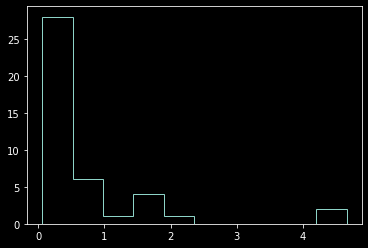

In [2]:
data = pd.read_csv("./data/2D/limit_expected_values.csv")
print(data.describe())
print(f"Any nan values? {data.isnull().values.any()}")
data['limit'].hist( histtype='step', grid=False);
data.head()

Summary of data cleaning
- no upper cuts are necessary limit belongs [0,5]
- transform limit into log limit
- normalization of parameters: each parameter is normalized independently, mzp $\leftarrow$ max(mzp) - mzp / max(mzp) - min(mzp)
  This must be done AFTER train/test split


Wait the log is only necessary for the 4D dataset because we have humungous values for limit. for now only 0-1 standarization will suffice

In [3]:
#train vs test split
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

In [4]:
#normalize, MinMaxScaler norms each feature independently
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_train[['mzp', 'mdh', 'limit']])

norm_data_train = pd.DataFrame(scaler.transform(data_train), columns=data.columns)
norm_data_test = pd.DataFrame(scaler.transform(data_test), columns=data.columns)

Looks like normalization is healthy 

In [5]:
#to torch
x_train = torch.Tensor(norm_data_train[['mzp', 'mdh']].values)
y_train = torch.Tensor(norm_data_train['limit'].values)
print(x_train.shape, y_train.shape)
x_test = torch.Tensor(norm_data_test[['mzp', 'mdh']].values)
y_test = torch.Tensor(norm_data_test['limit'].values)
print(x_test.shape, y_test.shape)

torch.Size([33, 2]) torch.Size([33])
torch.Size([9, 2]) torch.Size([9])


# 2. Define GP model to use

In [6]:
import gpytorch

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train, likelihood):
        super(ExactGPModel, self).__init__(x_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# 3. Train the model

In [7]:
# initialize likelihood and model    
x_train = x_train.to(device) 
y_train = y_train.to(device)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood = likelihood.to(device)

model = ExactGPModel(x_train, y_train, likelihood)
model = model.to(device)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
#SAVE_PATH = './bestmodel_1Dtruth_exp.pth' #save 

training_iterations = 10000
best_loss = 1E10
losses = []
hyperparams = []

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(x_train) 
    loss = -mll(output, y_train.view(-1)) # .contiguous() #avoid running into shape error
    loss.backward(retain_graph=True)
    losses.append(loss.item())
    hyperparams.append([model.covar_module.outputscale.item(), model.covar_module.base_kernel.lengthscale.item()])
    if(i%500==0):
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    #save model
    if(loss < best_loss):
        best_loss = loss
        #torch.save({
        #    'epoch': i,
        #    'model_state_dict': model.state_dict(),
        #    'optimizer_state_dict': optimizer.state_dict(),
        #    'loss': loss}, SAVE_PATH)
    
    optimizer.step()

Iter 1/10000 - Loss: 0.882
Iter 501/10000 - Loss: 0.679
Iter 1001/10000 - Loss: 0.476
Iter 1501/10000 - Loss: 0.282
Iter 2001/10000 - Loss: 0.111
Iter 2501/10000 - Loss: -0.032
Iter 3001/10000 - Loss: -0.155
Iter 3501/10000 - Loss: -0.246
Iter 4001/10000 - Loss: -0.310
Iter 4501/10000 - Loss: -0.362
Iter 5001/10000 - Loss: -0.402
Iter 5501/10000 - Loss: -0.430
Iter 6001/10000 - Loss: -0.444
Iter 6501/10000 - Loss: -0.450
Iter 7001/10000 - Loss: -0.451
Iter 7501/10000 - Loss: -0.452
Iter 8001/10000 - Loss: -0.452
Iter 8501/10000 - Loss: -0.452
Iter 9001/10000 - Loss: -0.452
Iter 9501/10000 - Loss: -0.452


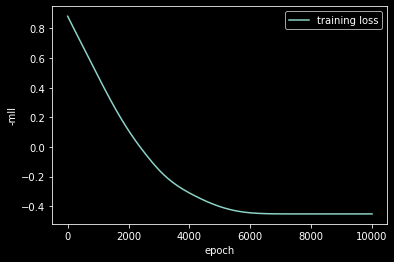

In [8]:
plt.plot(range(training_iterations), losses, label='training loss')
plt.xlabel('epoch')
plt.ylabel('-mll')
plt.legend();

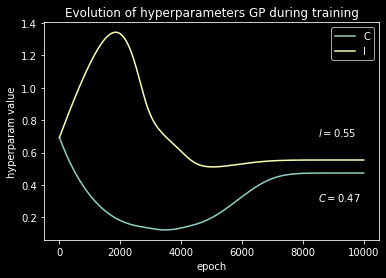

In [9]:
plt.plot(range(training_iterations), np.array(hyperparams)[:,0],label='C')
plt.plot(range(training_iterations), np.array(hyperparams)[:,1],label='l')
plt.xlabel('epoch')
plt.ylabel('hyperparam value')
plt.title('Evolution of hyperparameters GP during training')
plt.text(8500,0.3, f'$C = {np.array(hyperparams)[:,0][-1]:.2f}$', fontsize=10)
plt.text(8500,0.7, f'$l = {np.array(hyperparams)[:,1][-1]:.2f}$', fontsize=10)

plt.legend();


$$  k_{RBF}(X, X') = C \exp\left(-\frac{|| X-X' ||^2}{2l^2}\right) $$

# 4. Evaluate training 

In [10]:
# calcaulte test error
model.eval()
likelihood.eval()
test_loss = -mll(model(x_test), y_test)
print(f'The loss on test set is {test_loss:.2f}')
print(f"The best loss in training is {losses[-1]:.2f}")
print(f"The percentage { (test_loss/losses[-1])*100 :.2f} per cent")

The loss on test set is -1.24
The best loss in training is -0.45
The percentage 275.46 per cent


In [11]:
#make prediction
n = 1000
eval_x = torch.zeros(int(pow(n, 2)), 2)
for i in range(n):
    for j in range(n):
        eval_x[i * n + j][0] = float(i) / (n-1)
        eval_x[i * n + j][1] = float(j) / (n-1)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(eval_x))
    mean = observed_pred.mean

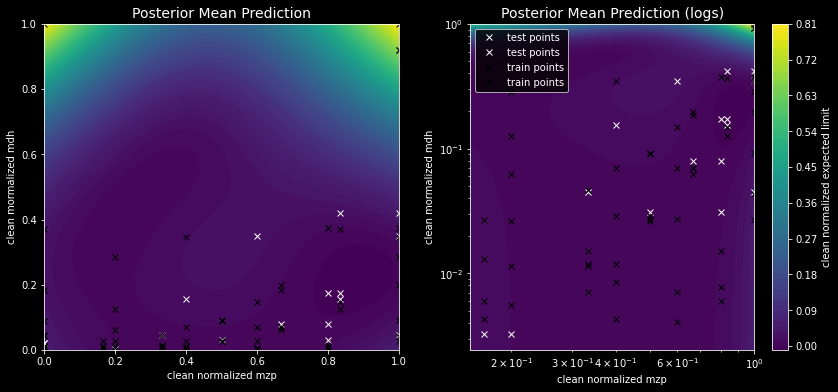

In [12]:
#plot prediction
mzp = np.linspace(0, 1.0, n)
mdh = np.linspace(0, 1.0, n)
MZP, MDH = np.meshgrid(mzp, mdh)

fig,ax = plt.subplots(1,2, figsize=(14,6))

cp=ax[0].contourf(MZP, MDH, mean.view(n,n), 100)
ax[0].plot(x_test, y_test, 'wx', label='test points')
ax[0].plot(x_train, y_train, 'kx', label='train points')
ax[0].set_xlabel('clean normalized mzp', fontsize=10)
ax[0].set_ylabel('clean mormalized mdh', fontsize=10)
ax[0].set_title('Posterior Mean Prediction', fontsize=14)
plt.colorbar(cp, label="clean normalized expected limit") 


ax[1].contourf(MZP, MDH, mean.view(n,n), 100)
ax[1].plot(x_test, y_test, 'wx', label='test points')
ax[1].plot(x_train, y_train, 'kx', label='train points')
ax[1].set_xlabel('clean normalized mzp', fontsize=10)
ax[1].set_ylabel('clean mormalized mdh', fontsize=10)
ax[1].set_title('Posterior Mean Prediction (logs)', fontsize=14)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
plt.legend()

In [13]:
#now the same plots but with inverse transformation to see the real parameter values 

#also plot in 3D showing the mean in 2D and seeing where the image of the test points goes, is it too bad the fit?

#repeat everything for 4D but no plots. Now I can go to major AL task with prior mean and multiresoluton.

In [14]:
lower, upper = observed_pred.confidence_region()
lower=lower.detach()
upper=upper.detach()
print(mean.shape)
lower.shape
print(type(mean))
mean.view(n,n)+upper.view(n,n)



x = np.outer(np.linspace(-2, 2, 30), np.ones(30))
y = x.copy().T # transpose
z = np.cos(x ** 2 + y ** 2)

print(x.shape, y.shape, z.shape)
print(MZP.shape, MDH.shape, mean.view(n,n).numpy().shape)
print(MZP.shape, MDH.shape, mean.view(n,n).numpy())

torch.Size([1000000])
<class 'torch.Tensor'>
(30, 30) (30, 30) (30, 30)
(1000, 1000) (1000, 1000) (1000, 1000)
(1000, 1000) (1000, 1000) [[0.04841363 0.04809415 0.0477742  ... 0.05274045 0.05306852 0.05339754]
 [0.0482415  0.04792058 0.04760301 ... 0.05235136 0.05267799 0.05300748]
 [0.04806793 0.0477494  0.04743278 ... 0.05196226 0.05228937 0.052616  ]
 ...
 [0.7946304  0.79263914 0.7906536  ... 0.79545057 0.79704225 0.79863584]
 [0.79681623 0.79482687 0.7928337  ... 0.79714334 0.79873884 0.80033433]
 [0.79900587 0.7970108  0.7950195  ... 0.798838   0.8004335  0.8020328 ]]


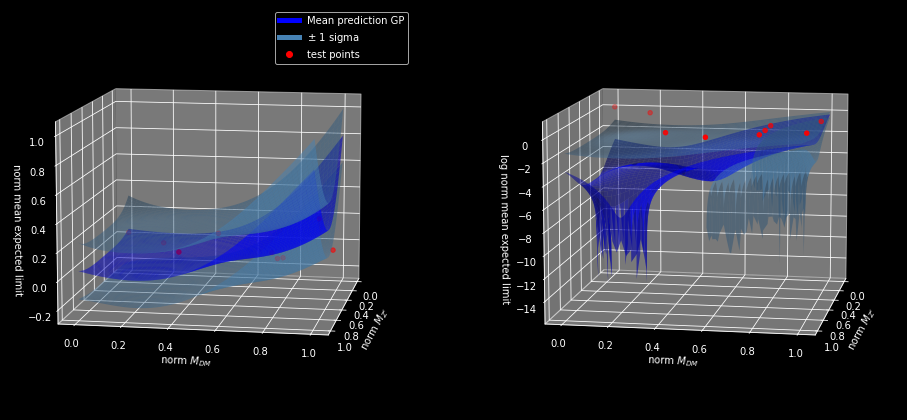

In [15]:
import matplotlib as mpl

fig = plt.figure( figsize=(16.0,8.0))

ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(MZP, MDH, mean.numpy().reshape(n,n), alpha=0.6,color='blue')
surf2 = ax.plot_surface(MZP, MDH, (upper).numpy().reshape(n,n), alpha=0.5, color='steelblue')
surf3 = ax.plot_surface(MZP, MDH, (lower).numpy().reshape(n,n), alpha=0.5, color='steelblue')
ax.scatter(x_test[:,0],x_test[:,1], y_test, color='red', marker='o')
ax.set_xlabel("norm $M_{Z'}$")
ax.set_ylabel('norm $M_{DM}$')
ax.set_zlabel(' norm mean expected limit')
ax.view_init(10, 10);
surf_line = mpl.lines.Line2D([0],[0], c='b', lw=5)
surf2_line = mpl.lines.Line2D([0],[0], c='steelblue', lw=5)
point_line = mpl.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
ax.legend([surf_line, surf2_line, point_line], ['Mean prediction GP', '$\pm$ 1 sigma', 'test points'], numpoints = 1)



ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(MZP, MDH, np.log(mean.numpy()).reshape(n,n), alpha=0.6,color='blue')
surf2 = ax.plot_surface(MZP, MDH, np.log((upper).numpy()).reshape(n,n), alpha=0.5, color='steelblue')
surf3 = ax.plot_surface(MZP, MDH, np.log((lower).numpy()).reshape(n,n), alpha=0.5, color='steelblue')
ax.scatter(x_test[:,0],x_test[:,1], y_test, color='red', marker='o')
ax.set_xlabel("norm $M_{Z'}$")
ax.set_ylabel('norm $M_{DM}$')
ax.set_zlabel('log norm mean expected limit')
ax.view_init(10, 10);
#fig.colorbar(surf, shrink=0.5, aspect=5)
fig.show()

x_test

Text(0, 0.5, '$M_{DH} [GeV]$')

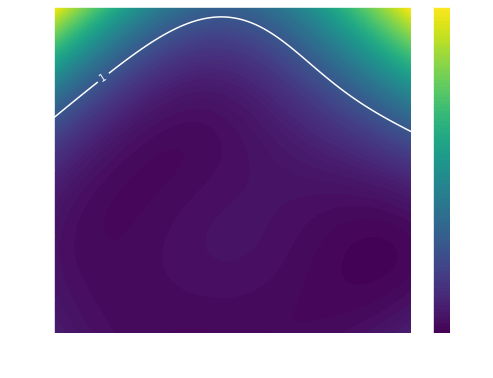

In [29]:
#scaler inverse transformation
#make prediction

    
array = np.stack([mzp, mdh, np.ones(n)], axis=1)
array = scaler.inverse_transform(array)
vector = np.stack([np.ones(n*n), np.ones(n*n), mean], axis=1)
vector = scaler.inverse_transform(vector)

mean_inv = vector[:,2].reshape(n,n)
MZP_inv, MDH_inv = np.meshgrid(array[:,0], array[:,1])


plt.figure(figsize=(8,6))

cp=plt.contourf(MZP_inv, MDH_inv, mean_inv, 100)
pl=plt.contour(MZP_inv, MDH_inv, mean_inv, [1.], colors='white', lw=3)
plt.clabel(pl, inline=1, fontsize=10)
plt.colorbar(cp, label="expected limit") 
#plt.plot(x_test, y_test, 'wx', label='test points')
plt.xlabel("$M_{Z'} [GeV]$", fontsize=14)
plt.ylabel("$M_{DH} [GeV]$",  fontsize=14)



# Active Learning

In [18]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [19]:
np.warnings.filterwarnings('ignore')
import excursion

In [21]:
model;

In [56]:
#load true toy "reco" data
import excursion.testcases.fast_2D as testcase_details
n = 1000
eval_x = torch.zeros(int(pow(n, 2)), 2)
for i in range(n):
    for j in range(n):
        eval_x[i * n + j][0] = float(i) / (n-1)
        eval_x[i * n + j][1] = float(j) / (n-1)
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(eval_x))
    mean = observed_pred.mean

    
array = np.stack([mzp, mdh, np.ones(n)], axis=1)
array = scaler.inverse_transform(array)
vector = np.stack([np.ones(n*n), np.ones(n*n), mean], axis=1)
vector = scaler.inverse_transform(vector)
mean_inv = vector[:,2].reshape(n,n)
MZP_inv, MDH_inv = np.meshgrid(array[:,0], array[:,1])




#levels.collections[0].set_label('excursion set at t= 1')
#cbar = plt.colorbar(levels)
#cbar.ax.set_ylabel('f(x,y)')

#plt.title('2D_fast.py')
#plt.legend(loc=0)
#plt.show()

Text(0, 0.5, '$M_{DH} [GeV]$')

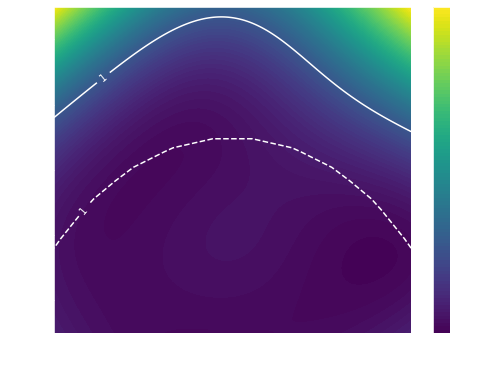

In [117]:
plt.figure(figsize=(8,6))
cp=plt.contourf(MZP_inv, MDH_inv, mean_inv, 100)
pl=plt.contour(MZP_inv, MDH_inv, mean_inv, [1.], colors='white', lw=3)
plt.colorbar(cp, label="expected limit") 

#plt.plot(x_test, y_test, 'wx', label='test points')
##########true
for func in testcase_details.true_functions:
    ix,iy = testcase_details.plot_meshgrid
    X = testcase_details.X
    cont = excursion.utils.values2mesh(func(X), testcase_details.rangedef, testcase_details.invalid_region)
    levels = plt.contour(ix,iy,cont, 100, alpha=0.);
    pl2 = plt.contour(ix,iy,cont, [1.], colors='white', linestyles='dashed', lw=3)
    plt.clabel(pl2, inline="1", fontsize=10)
    
plt.clabel(pl, inline="1", fontsize=10)
plt.xlabel("$M_{Z'} [GeV]$", fontsize=14)
plt.ylabel("$M_{DH} [GeV]$",  fontsize=14)
